In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


In [3]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            image_path = f"{data_dir}/{directory}/{files}"
            image_list.append(convert_image_to_array(image_path))
            label_list.append(binary_labels[all_labels.index(directory)])
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    class_labels = classes
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    predictions = model.predict(image.reshape(1, 256, 256, 3))

    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    prediction_values = predictions[0]

    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()



In [ ]:
dir_path = r"C:\Users\bushr\Downloads\Compressed/archive_5"

all_labels = [i.split('/')[-1] for i in os.listdir(dir_path)]
binary_labels = [int(i) for i in range(len(all_labels))]

images, labels = load_dataset(dir_path)

In [5]:
all_labels

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05, random_state=42  # 20% for testing
)

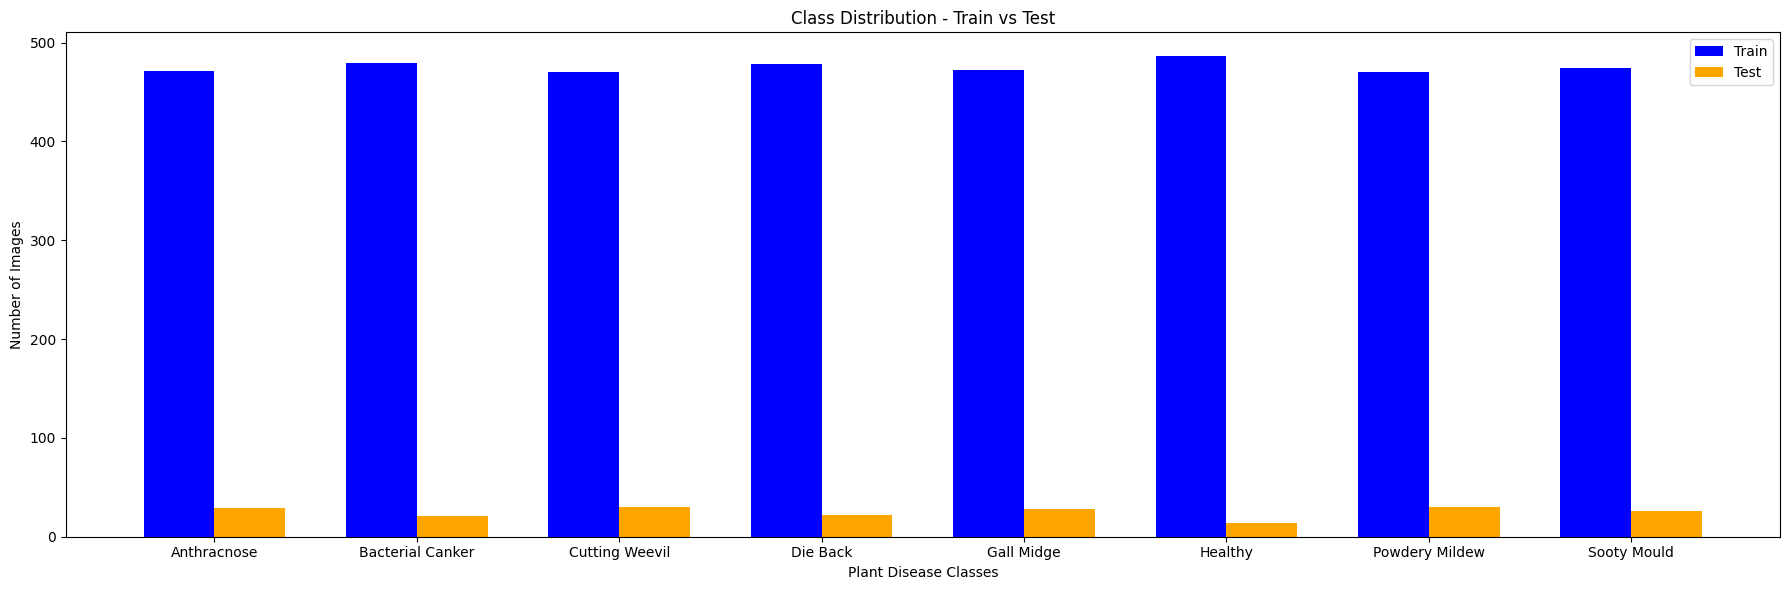

In [7]:
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels, minlength=3)

classes = all_labels
train_colors = 'blue'
test_colors = 'orange'
bar_width = 0.35
index = np.arange(len(classes))
plt.figure(figsize=(18, 6))
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')
plt.bar(index + bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution - Train vs Test")
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0
x_test = np.array(test_images, dtype=np.float16) / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (3800, 256, 256, 3)
x_test shape: (200, 256, 256, 3)
y_train shape: (3800, 8)
y_test shape: (200, 8)


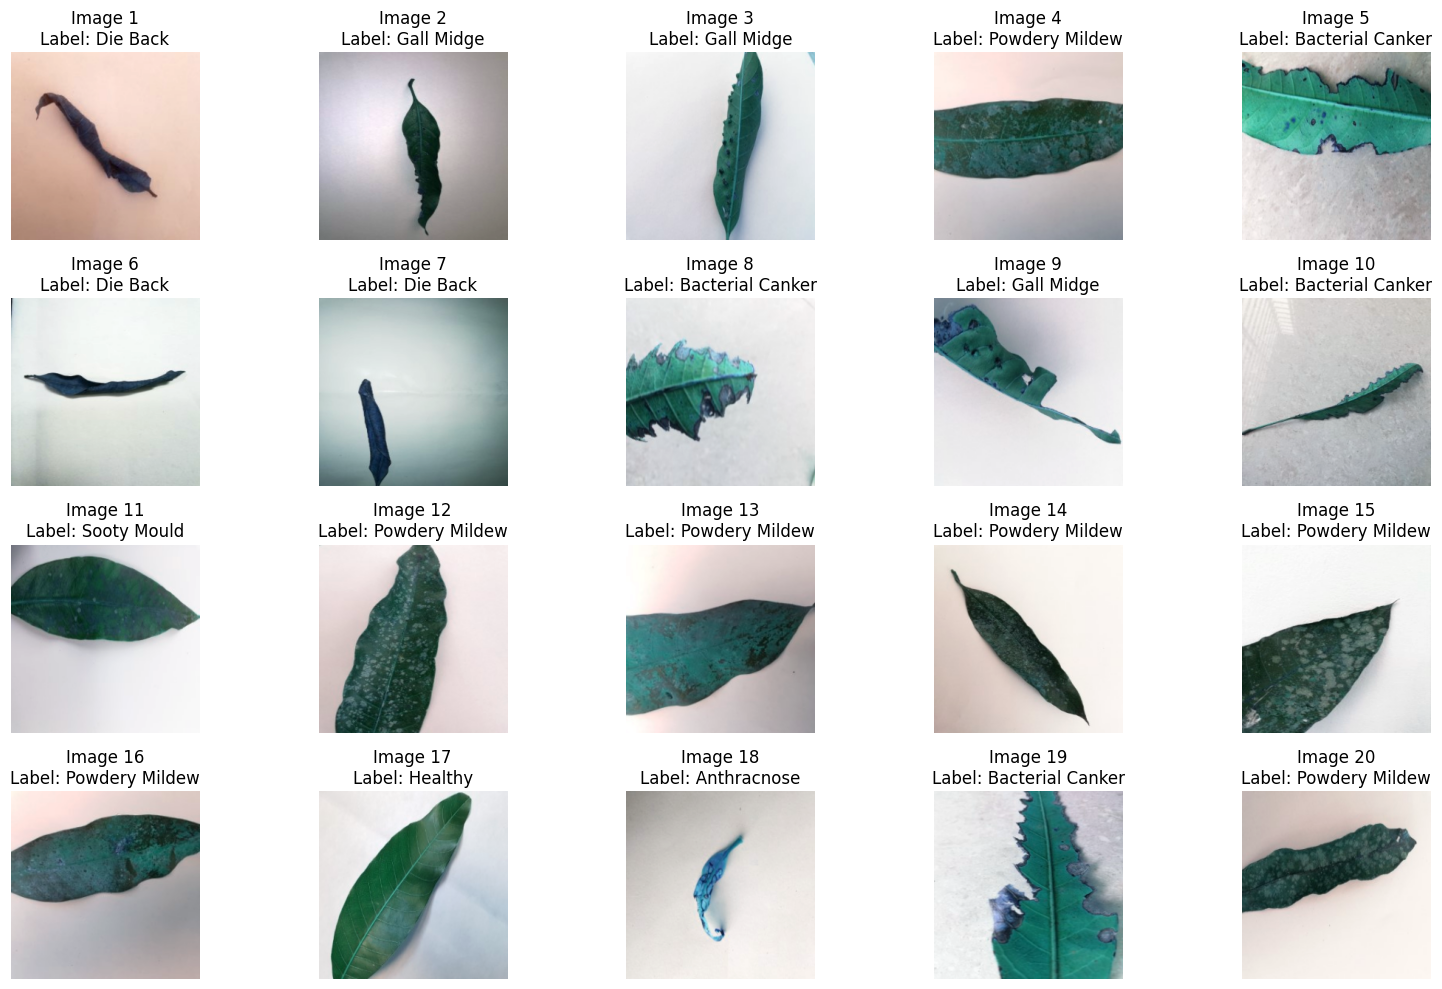

In [9]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

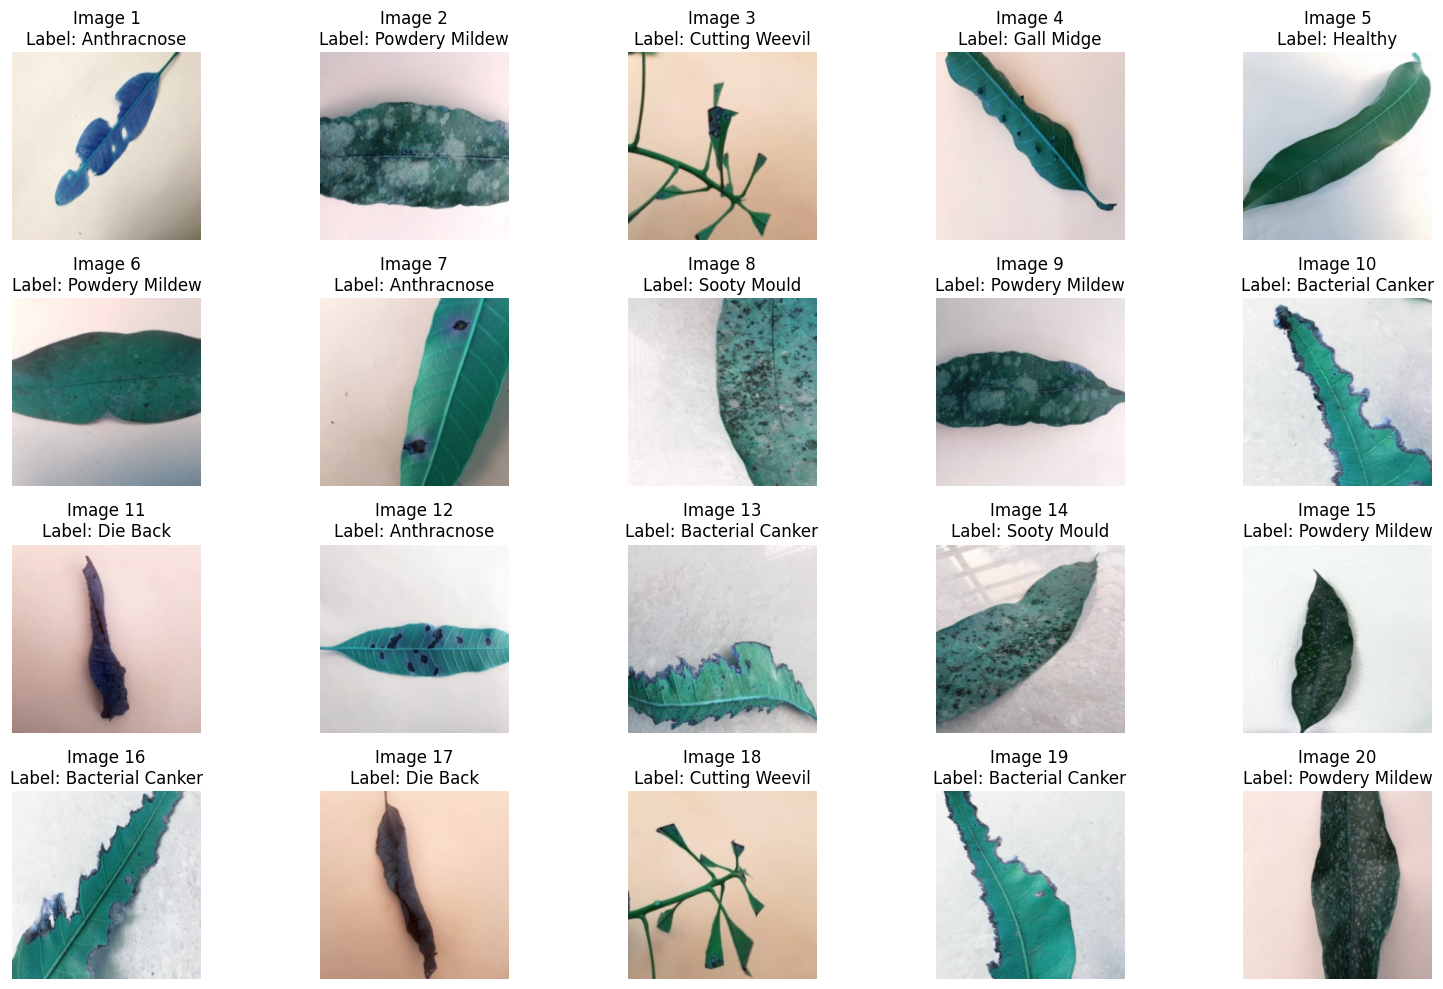

In [10]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20)

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.regularizers import l2

# Function to build models using popular CNN architectures
def build_model(model_name):
    if model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(256, 256, 3))
    elif model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))
    else:
        base_model = Sequential([
            Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(256, 256, 3)),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(256, (5, 5), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(384, (3, 3), padding="same", activation='relu'),
            Conv2D(256, (3, 3), padding="same", activation='relu'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            Flatten(),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(4096, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.6),
            Dense(len(classes), activation='softmax')
        ])
        return base_model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(len(classes), activation='softmax')
    ])

    return model


#### Only Single Model VGG16

Training VGG16 model...
Epoch 1/10
190/190 [==============================] - 67s 272ms/step - loss: 6.0003 - accuracy: 0.7612 - val_loss: 4.3616 - val_accuracy: 0.9658
Epoch 2/10
190/190 [==============================] - 49s 259ms/step - loss: 3.7297 - accuracy: 0.9546 - val_loss: 3.1266 - val_accuracy: 0.9553
Epoch 3/10
190/190 [==============================] - 49s 259ms/step - loss: 2.7260 - accuracy: 0.9589 - val_loss: 2.3117 - val_accuracy: 0.9816
Epoch 4/10
190/190 [==============================] - 49s 259ms/step - loss: 2.0095 - accuracy: 0.9872 - val_loss: 1.8204 - val_accuracy: 0.9724
Epoch 5/10
190/190 [==============================] - 49s 259ms/step - loss: 1.5660 - accuracy: 0.9951 - val_loss: 1.4258 - val_accuracy: 0.9842
Epoch 6/10
190/190 [==============================] - 49s 260ms/step - loss: 1.3111 - accuracy: 0.9776 - val_loss: 1.1402 - val_accuracy: 0.9882
Epoch 7/10
190/190 [==============================] - 50s 261ms/step - loss: 1.0442 - accuracy: 0.9855 - v

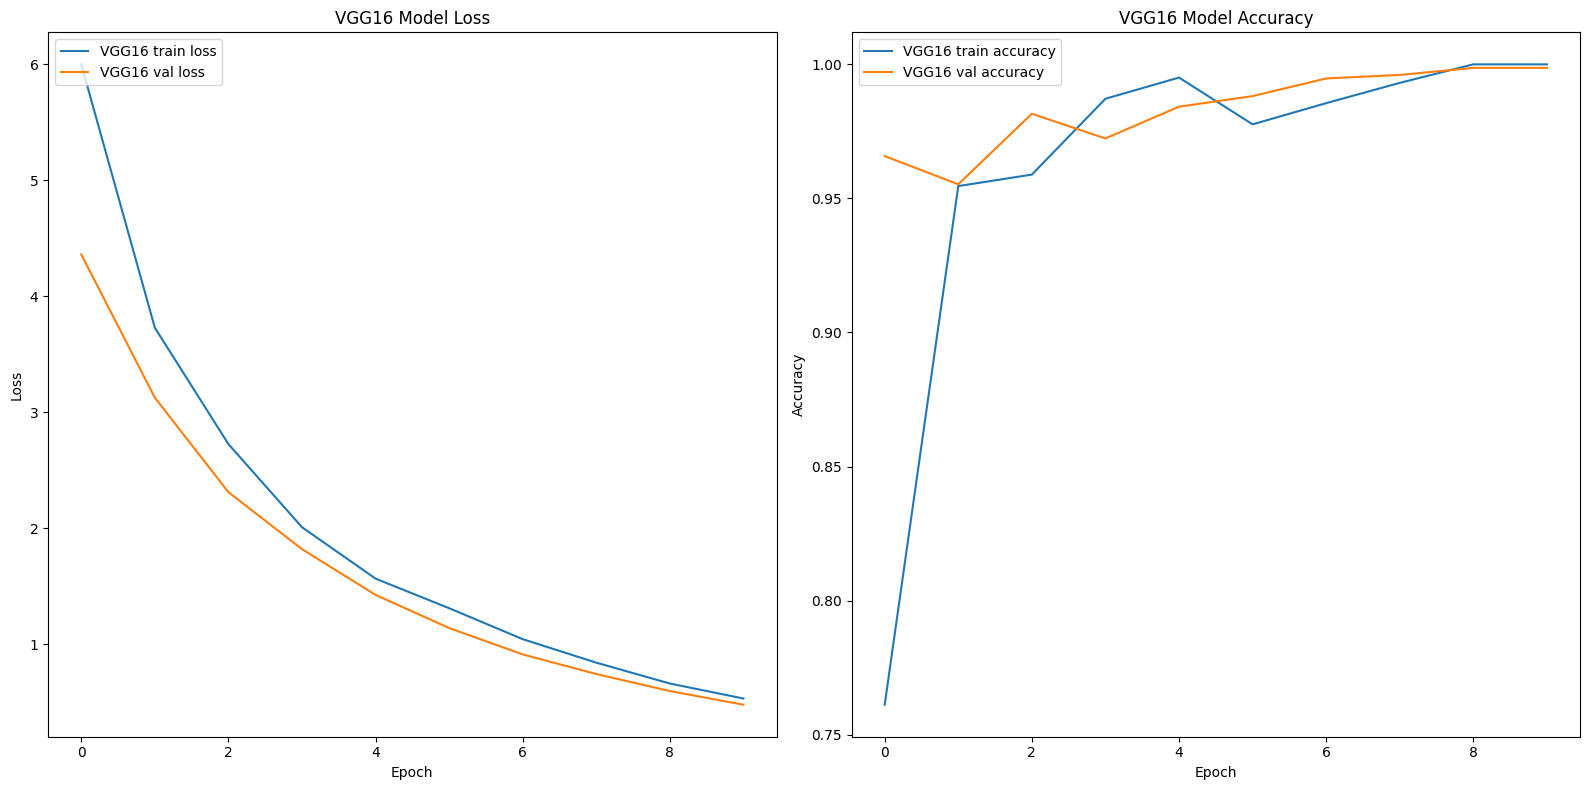

In [12]:
models = ['VGG16'] # Changed this line
history_dict = {}
best_weights = {}

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

for model_name in models:
    print(f"Training {model_name} model...")
    # Assuming build_model(model_name) correctly builds the specified model
    model = build_model(model_name)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=10,
        validation_data=(x_val, y_val),  # Validation data for validation split
        verbose=1
    )

    history_dict[model_name] = history.history
    best_weights[model_name] = model
    print(f"{model_name} model weights saved.")


    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    # Loss plot
    ax[0].plot(history.history['loss'], label=f'{model_name} train loss')
    ax[0].plot(history.history['val_loss'], label=f'{model_name} val loss')
    ax[0].set_title(f'{model_name} Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')
    # Accuracy plot
    ax[1].plot(history.history['accuracy'], label=f'{model_name} train accuracy')
    ax[1].plot(history.history['val_accuracy'], label=f'{model_name} val accuracy')
    ax[1].set_title(f'{model_name} Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

#### VGG16 Confusion Matrix

Evaluating VGG16 model on test data...
VGG16 Test Accuracy: 97.00%
7/7 [==============================] - 1s 121ms/step


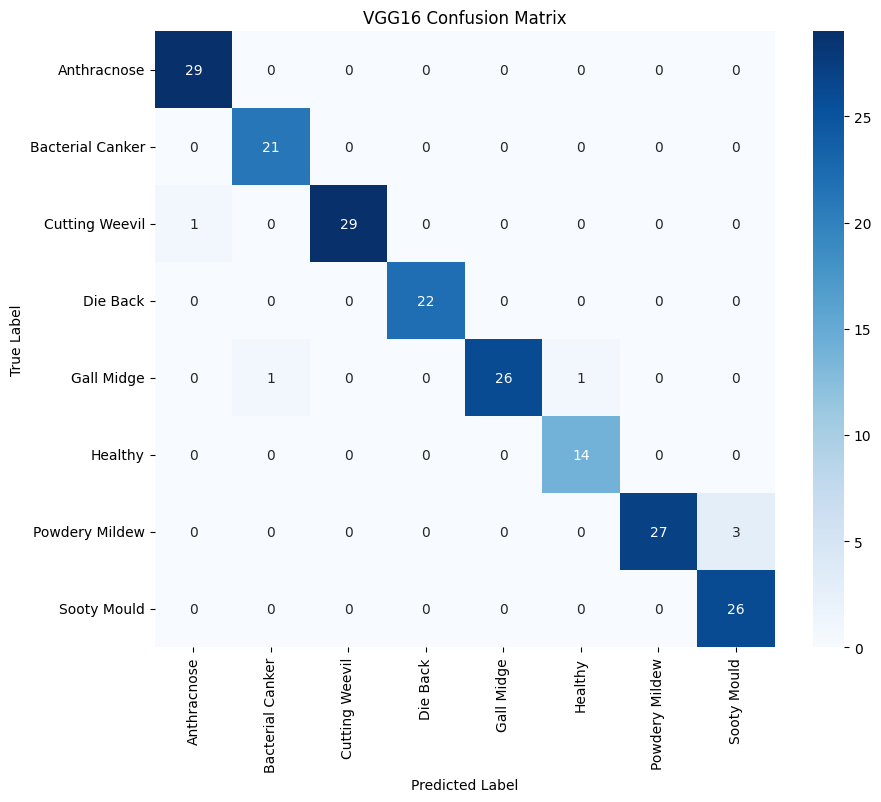

                  precision    recall  f1-score   support

     Anthracnose       0.97      1.00      0.98        29
Bacterial Canker       0.95      1.00      0.98        21
  Cutting Weevil       1.00      0.97      0.98        30
        Die Back       1.00      1.00      1.00        22
      Gall Midge       1.00      0.93      0.96        28
         Healthy       0.93      1.00      0.97        14
  Powdery Mildew       1.00      0.90      0.95        30
     Sooty Mould       0.90      1.00      0.95        26

        accuracy                           0.97       200
       macro avg       0.97      0.97      0.97       200
    weighted avg       0.97      0.97      0.97       200



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

for model_name in models:
    print(f"Evaluating {model_name} model on test data...")
    model = best_weights[model_name]

    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} Test Accuracy: {scores[1] * 100:.2f}%")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=classes))


#### VGG16 Model Testing



Testing - VGG16 Model

1/1 [==============================] - 1s 804ms/step


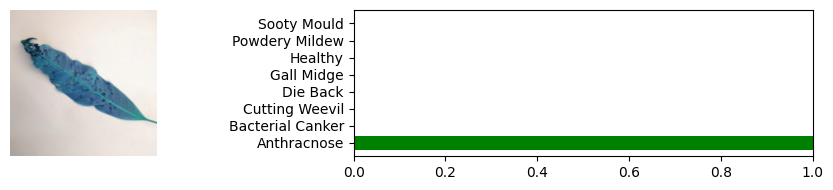



Testing - VGG16 Model

1/1 [==============================] - 0s 13ms/step


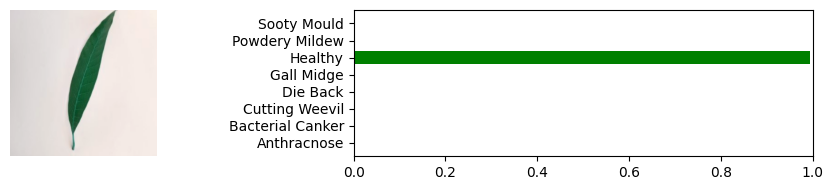



Testing - VGG16 Model

1/1 [==============================] - 0s 17ms/step


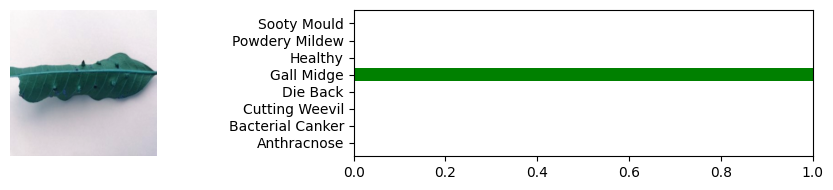

In [14]:

for model_name in models:
    for i in x_test[100:103]:
        print(f"\n\nTesting - {model_name} Model\n")
        output_plot(i, best_weights[model_name])
